In [1]:
import pdb
import os
import itertools
from tqdm import tqdm

import pandas as pd
import numpy as np

from sklearn.feature_selection import mutual_info_regression as MI
from scipy import stats as st

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()


import sys
sys.path.append('/home/leonardo/git/bayesian_bss')
from src import MAPGradientEstimator, InstantaneousMixtureModel

np.random.seed(666)

# 1. Initialize Sources

In [2]:
def source_cumulative(x):
    return 1/(1+np.exp(-x))

def source_pdf(x):
    return np.exp(-x)/np.square(1+np.exp(-x))

def source_pdf_derivative(x):
    return (2*np.exp(-2*x)*(1+np.exp(-x)) - np.exp(-x)*np.square(1+np.exp(-x)))/np.power([1+np.exp(-x)],[4])

----------------------------------------------------------------------------------------------------
NÚMERO DE FONTES: 2
TAMANHO DOS SINAIS DAS FONTES: 1000
CURTOSE s0: 0.8442485120938028
CURTOSE s1: 1.1088052414340286
----------------------------------------------------------------------------------------------------


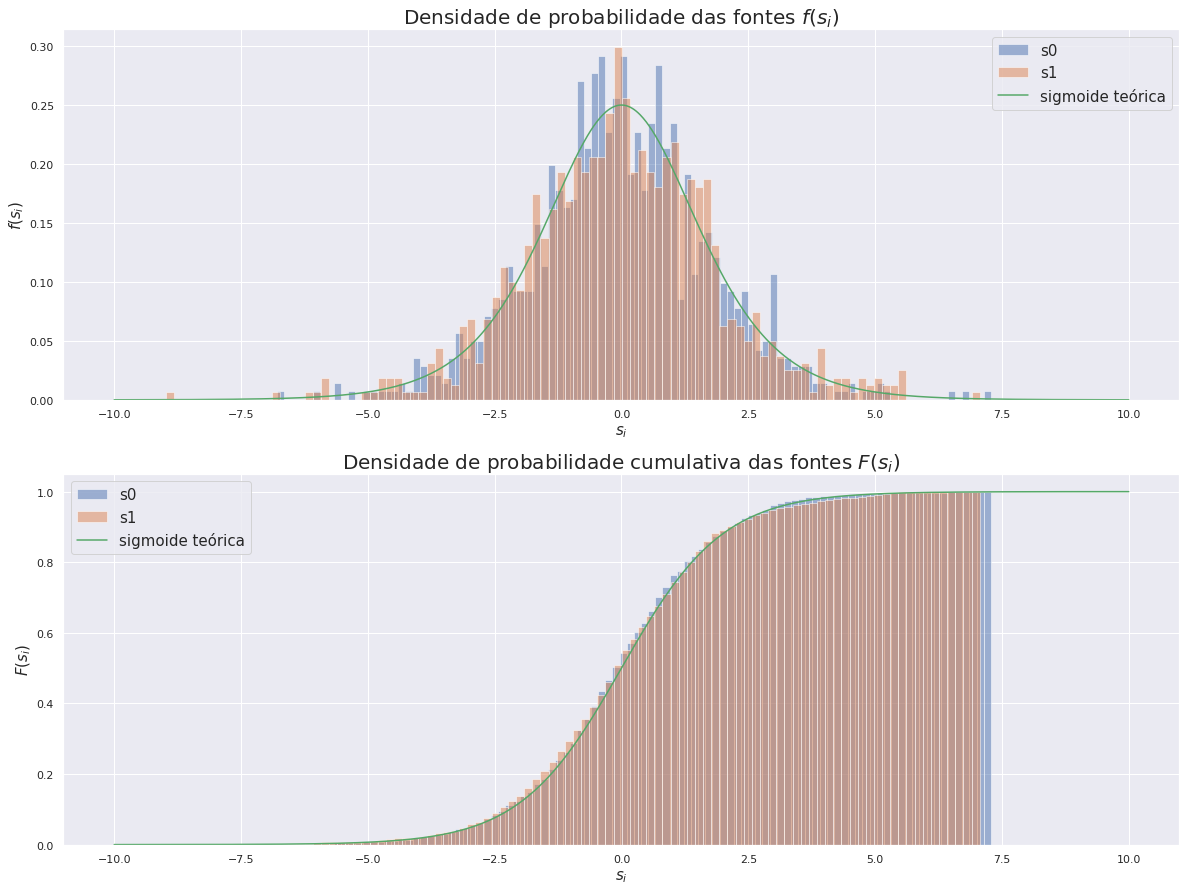

In [3]:
NSOURCES=2
NOBS=1000

s = np.random.logistic(
    loc=0,
    scale=1,
    size=(NSOURCES, NOBS)
)

print('-'*100)
print('NÚMERO DE FONTES: {}'.format(NSOURCES))
print('TAMANHO DOS SINAIS DAS FONTES: {}'.format(NOBS))
for i in range(s.shape[0]):
    print(
        'CURTOSE s{}: {}'.format(
            i,
            st.kurtosis(a=s[i,:])
        )
    )
    
print('-'*100)

fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(20,15)
)


for i in range(1, NSOURCES+1):
    ax1.hist(
        x=s[i-1,:],
        bins=100,
        density=True,
        label='s{}'.format(i-1),
        alpha=0.5
    )
    ax2.hist(
        x=s[i-1,:],
        bins=100,
        cumulative=True,
        density=True,
        label='s{}'.format(i-1),
        alpha=0.5
    )
    
ax1.plot(
    np.linspace(-10,10,1000),
    [source_pdf(x) for x in np.linspace(-10,10,1000)],
    label='sigmoide teórica'
)


ax2.plot(
    np.linspace(-10,10,1000),
    [source_cumulative(x) for x in np.linspace(-10,10,1000)],
    label='sigmoide teórica'
)

ax1.set_xlabel(
    '$s_{i}$',
    fontsize=15
)
ax1.set_ylabel(
    '$f(s_{i})$',
    fontsize=15
)
ax1.set_title(
    'Densidade de probabilidade das fontes $f(s_{i})$',
    fontsize=20
)

ax2.set_xlabel(
    '$s_{i}$',
    fontsize=15
)
ax2.set_ylabel(
    '$F(s_{i})$',
    fontsize=15
)
ax2.set_title(
    'Densidade de probabilidade cumulativa das fontes $F(s_{i})$',
    fontsize=20
)

l1=ax1.legend(fontsize=15)
l2=ax2.legend(fontsize=15)


# 2. Mix sources and generate observations

In [4]:
# Mixing matrix
A = np.array([
    [1, 1],
    [-0.5, 0.5]
])
print('MIXING MATRIX A:')
print(A)

MIXING MATRIX A:
[[ 1.   1. ]
 [-0.5  0.5]]


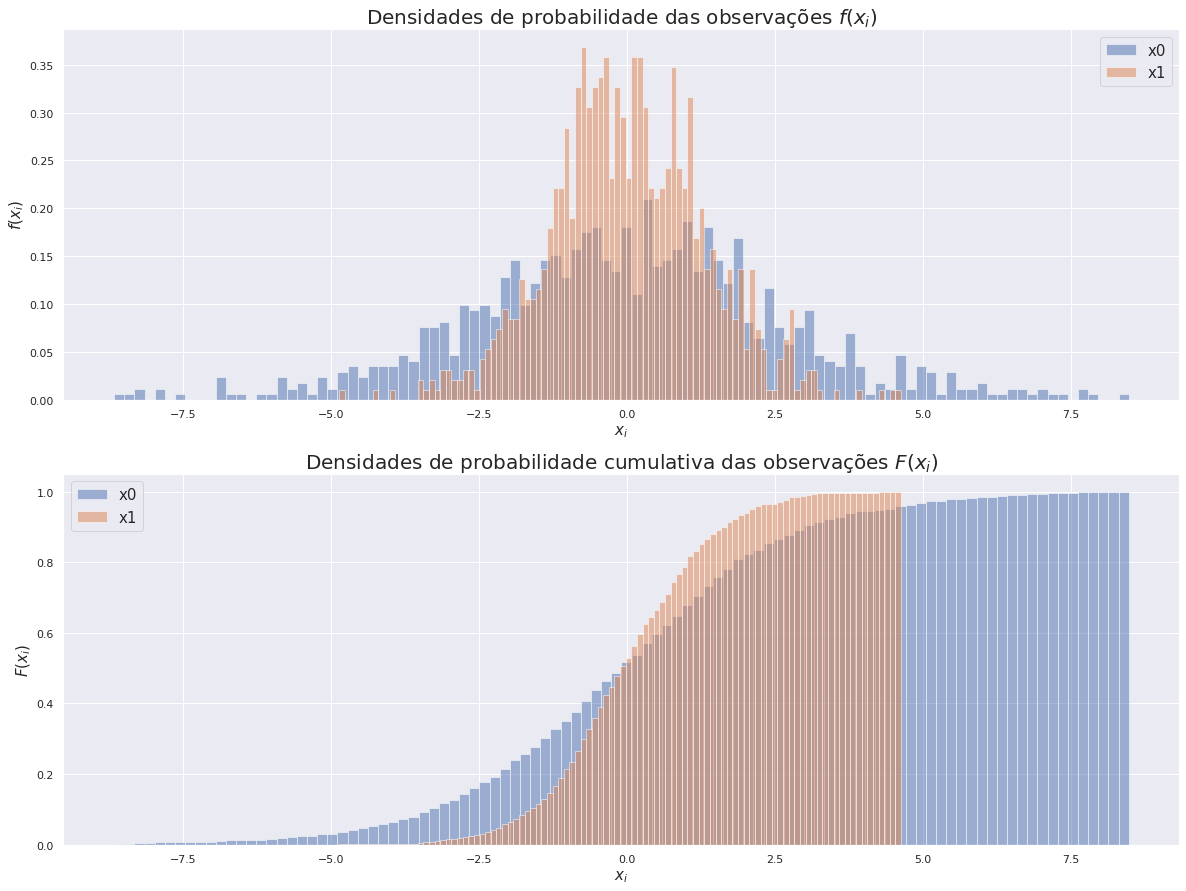

In [5]:
# Observed sources
x = A@s

fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(20,15)
)

for i in range(1, NSOURCES+1):
    ax1.hist(
        x=x[i-1,:],
        bins=100,
        density=True,
        label='x{}'.format(i-1),
        alpha=0.5
    )
    ax2.hist(
        x=x[i-1,:],
        bins=100,
        cumulative=True,
        density=True,
        label='x{}'.format(i-1),
        alpha=0.5
    )

ax1.set_xlabel(
    '$x_{i}$',
    fontsize=15
)
ax1.set_ylabel(
    '$f(x_{i})$',
    fontsize=15
)
ax1.set_title(
    'Densidades de probabilidade das observações $f(x_{i})$',
    fontsize=20
)

ax2.set_xlabel(
    '$x_{i}$',
    fontsize=15
)
ax2.set_ylabel(
    '$F(x_{i})$',
    fontsize=15
)
ax2.set_title(
    'Densidades de probabilidade cumulativa das observações $F(x_{i})$',
    fontsize=20
)

l1=ax1.legend(fontsize=15)
l2=ax2.legend(fontsize=15)

In [6]:
# Define initial conditions for optimizations
initial_B = np.random.normal(
    0,1,
    (NSOURCES, NSOURCES, 1)
)

# Learning rate
learning_rate=1E-3

# Optimization configs
thresh = 0.0005
max_it=100000

In [7]:
def source_pdf(x):
    return np.exp(-x)/np.square(1+np.exp(-x))

def source_pdf_derivative(x):
    return (2*np.exp(-2*x)*(1+np.exp(-x)) - np.exp(-x)*np.square(1+np.exp(-x)))/np.power([1+np.exp(-x)],[4])

# 3. Execute Maximum Likelihood optimization

In [8]:
def source_pdf(x):
    """
        This method takes SCALAR value x and return SCALAR source pdf evaluated at x.
    """
    return np.exp(-x)/np.square(1+np.exp(-x))


def source_pdf_derivative(x):
    """
        This method takes SCALAR value x and return SCALAR source pdf derivative evaluated at x.
    """
    return (2*np.exp(-2*x)*(1+np.exp(-x)) - np.exp(-x)*np.square(1+np.exp(-x)))/np.power([1+np.exp(-x)],[4])


def prior_pdf(X):
    """
        This method takes VECTOR value X and return SCALAR prior pdf evaluated at X.
    """
    return 1

def prior_pdf_derivative(X):
    """
        This method takes VECTOR value x and return VECTOR prior pdf derivative evaluated at X.
    """
    return np.zeros(
        shape=X.shape
    )

## 3.1. Standard Gradient

In [9]:
# Initialize estimator
estimator = MAPGradientEstimator(
    learning_rate=learning_rate,
    thresh=thresh,
    max_it=max_it,
    source_pdf=source_pdf,
    source_pdf_derivative=source_pdf_derivative,
    prior_pdf=prior_pdf,
    prior_pdf_derivative=prior_pdf_derivative,
    is_natural_gradient=False
)

In [10]:
%%time

# Run optimization
estimator.fit(
    s=s,
    x=x,
    initial_condition=initial_B,
    n_initializations=1,
    n_jobs=os.cpu_count()-1
)

# Parse results
B=estimator.fit_results[0]['unmixing_matrix']
logs=estimator.fit_results[0]['logs']

print('-'*100)
print('Total iterations: {}'.format(logs.shape[0]))
print('Final log-posteriori: {}'.format(logs.iloc[-1]['log_posteriori']))
print('-'*100)

/home/leonardo/git/bayesian_bss/src/estimator.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if initial_condition=='random':


----------------------------------------------------------------------------------------------------
Total iterations: 2322
Final log-posteriori: -4034.7131816351034
----------------------------------------------------------------------------------------------------
CPU times: user 10.1 ms, sys: 59.8 ms, total: 69.9 ms
Wall time: 1min 17s


In [11]:
# %%time

# # Inicialização aleatória de B

# B = initial_B
# logs = pd.DataFrame()


# continue_opt=True
# n=1

# last_posteriori = -np.inf
# print('-'*100)
# while continue_opt:
#     # Determinação de gradiente
#     deltaB = np.transpose(np.linalg.inv(B))
#     for t in range(NOBS):
#         x_t = x[:,t]
#         y_t = B@x_t
#         g_y = np.array([
#             source_pdf_derivative(y_t_i)/source_pdf(y_t_i) for y_t_i in y_t
#         ]).reshape((NSOURCES,1))
#         deltaB = deltaB + (1/NOBS)*(g_y@x_t.reshape((1,NSOURCES)))
    
#     # Atualização de matriz de separação B
#     B = B + learning_rate*deltaB
    
#     # Cálculo de posteriori para registros
#     posteriori = NOBS*np.log(np.abs(np.linalg.det(B)))
#     y=B@x
#     for i, j in np.ndindex(x.shape):
#         posteriori += np.log(source_pdf(y[i,j]))
    
#     logs = pd.concat(
#         [
#             logs,
#             pd.DataFrame(
#                 index=[n],
#                 data={
#                     'iteration': [n+1],
#                     'detB': [np.linalg.det(B)],
#                     'log_posteriori': [posteriori],
#                     'gradient': [deltaB]
#                 }
#             )
#         ]
#     )
    
    
#     if n==1:
#         n+=1
#         continue_opt=True
#         last_posteriori=posteriori
#     else:
#         n+=1
#         # pdb.set_trace()
#         continue_opt = (n<max_it) and (np.abs(posteriori-last_posteriori) > thresh)
#         last_posteriori=posteriori
    
#     if n%100==0:
#         print('Iteração: {}'.format(n))
#         print('Log-Posteriori: {}'.format(posteriori))
#         print('-'*100)    
    
    

Text(0.5, 1.0, 'Evolução da prob. a posteriori ao longo das iterações')

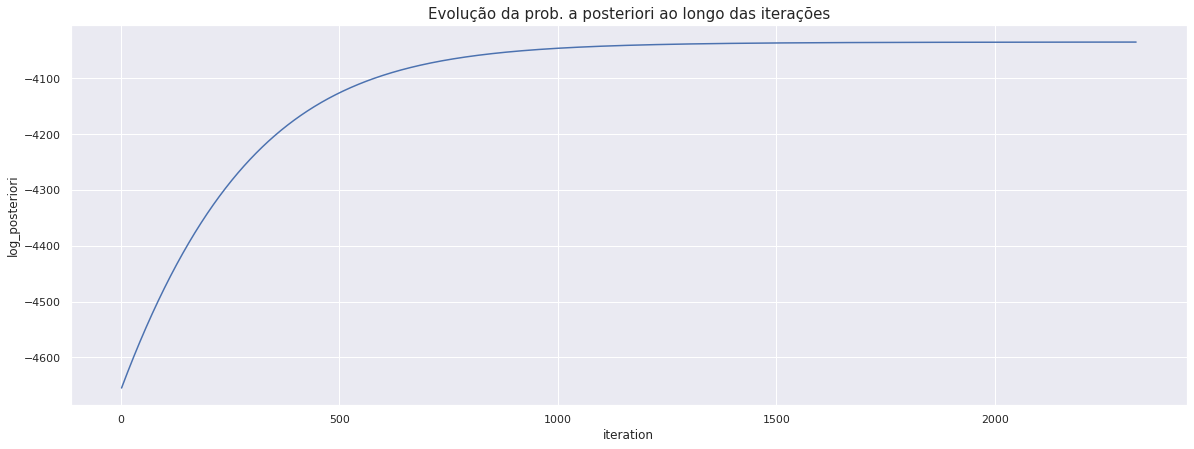

In [12]:
fig = plt.figure(figsize=(20,7))
sns.lineplot(
    data=logs,
    x='iteration',
    y='log_posteriori'
)
plt.title(
    'Evolução da prob. a posteriori ao longo das iterações',
    fontsize=15
)

Text(0.5, 1.0, 'Evolução do determinante de B ao longo das iterações')

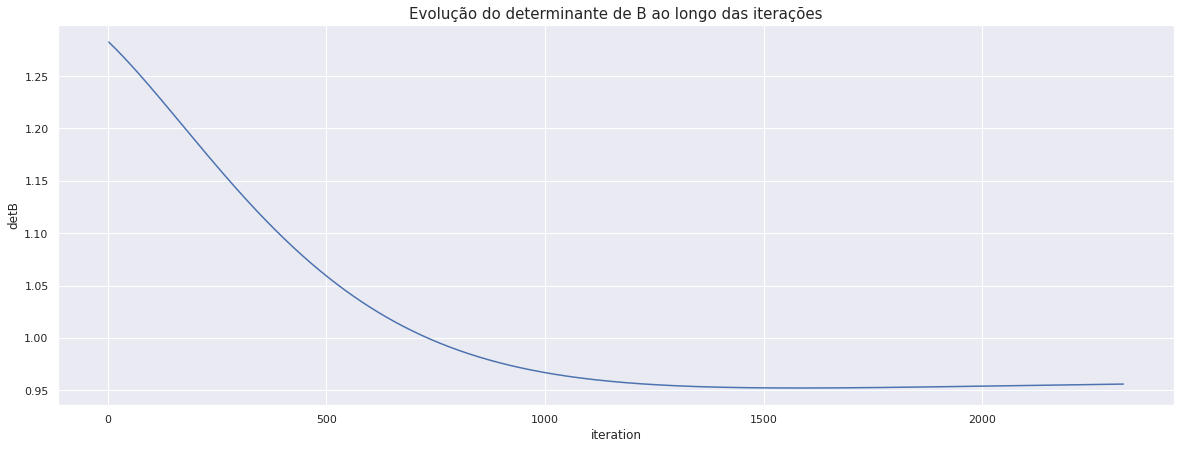

In [13]:
fig = plt.figure(figsize=(20,7))
sns.lineplot(
    data=logs,
    x='iteration',
    y='detB'
)
plt.title(
    'Evolução do determinante de B ao longo das iterações',
    fontsize=15
)

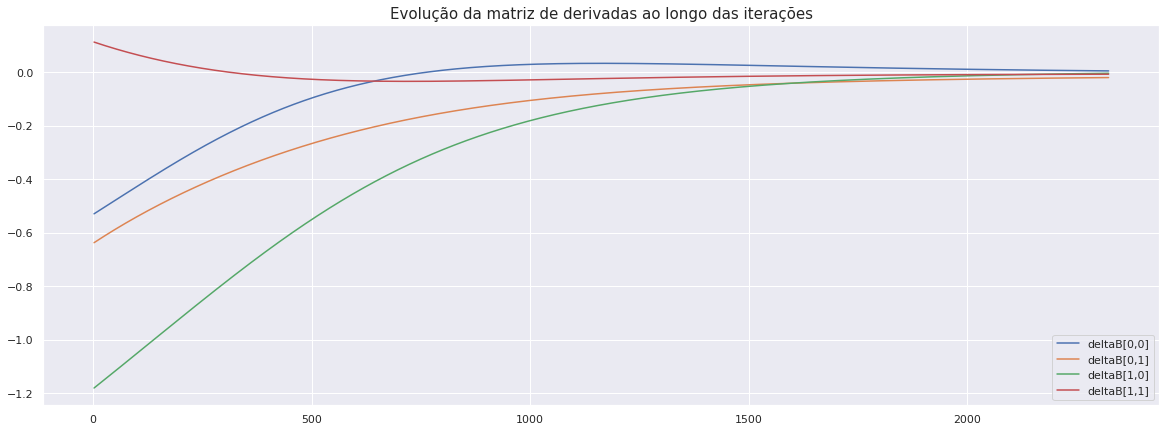

In [14]:
fig = plt.figure(figsize=(20,7))
for i, j in np.ndindex(B.shape):
    plt.plot(
        logs.iteration.values,
        [row['gradient'][i,j] for n, row in logs.iterrows()],
        label='deltaB[{},{}]'.format(i,j)
    )

plt.title(
    'Evolução da matriz de derivadas ao longo das iterações',
    fontsize=15
)
plt.legend()

In [15]:
B

array([[ 0.56444267, -0.83998475],
       [ 0.40135375,  1.09620562]])

In [16]:
np.linalg.inv(A)

array([[ 0.5, -1. ],
       [ 0.5,  1. ]])

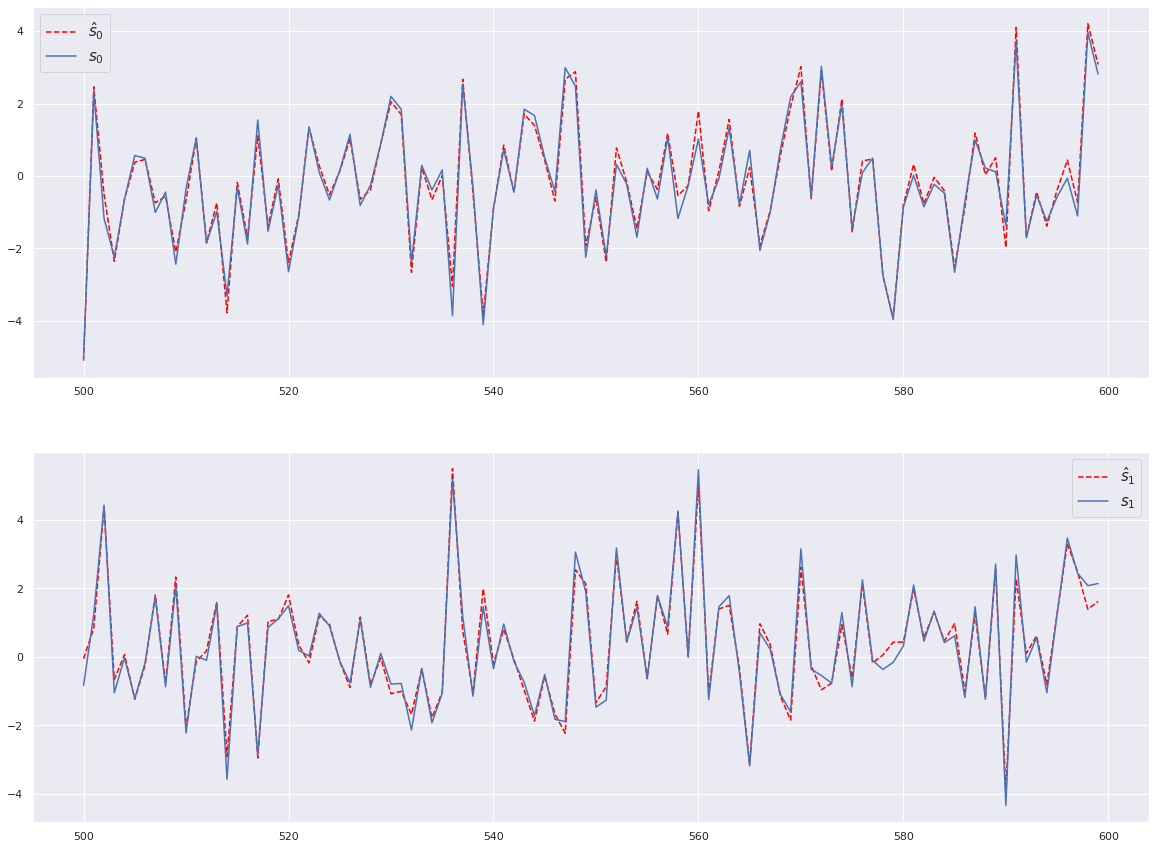

In [17]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(20,15)
)
NPOINTS=100
PLOT_START=NOBS//2
PLOT_END=PLOT_START+NPOINTS

t=range(NOBS)
s_est = B@x

#Ax1
ax1.plot(
    t[PLOT_START:PLOT_END],
    s_est[0,PLOT_START:PLOT_END],
    label='$\hat{s}_{0}$',
    color='red',
    linestyle='--'
)
ax1.plot(
    t[PLOT_START:PLOT_END],
    s[0,PLOT_START:PLOT_END],
    label='$s_{0}$'
)
ax1.legend(fontsize=15)

#Ax2
ax2.plot(
    t[PLOT_START:PLOT_END],
    s_est[1,PLOT_START:PLOT_END],
    label='$\hat{s}_{1}$',
    color='red',
    linestyle='--'
)
ax2.plot(
    t[PLOT_START:PLOT_END],
    s[1,PLOT_START:PLOT_END],
    label='$s_{1}$'
)
ax2.legend(fontsize=15)



In [18]:
# Error norm
print('Norma do erro de estimação: {}'.format(
np.linalg.norm(
    np.subtract(s,s_est)
)/np.size(s)))

Norma do erro de estimação: 0.006198507222686355


## 3.2. Natural Gradient

In [19]:
# Initialize estimator
estimator = MAPGradientEstimator(
    learning_rate=learning_rate,
    thresh=thresh,
    max_it=max_it,
    source_pdf=source_pdf,
    source_pdf_derivative=source_pdf_derivative,
    prior_pdf=prior_pdf,
    prior_pdf_derivative=prior_pdf_derivative,
    is_natural_gradient=True
)

In [20]:
%%time

# Run optimization
estimator.fit(
    s=s,
    x=x,
    initial_condition=initial_B,
    n_initializations=1,
    n_jobs=os.cpu_count()-1
)

# Parse results
B=estimator.fit_results[0]['unmixing_matrix']
logs=estimator.fit_results[0]['logs']

print('-'*100)
print('Total iterations: {}'.format(logs.shape[0]))
print('Final log-posteriori: {}'.format(logs.iloc[-1]['log_posteriori']))
print('-'*100)

/home/leonardo/git/bayesian_bss/src/estimator.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if initial_condition=='random':


----------------------------------------------------------------------------------------------------
Total iterations: 2487
Final log-posteriori: -4033.3352583416217
----------------------------------------------------------------------------------------------------
CPU times: user 6.6 ms, sys: 3.55 ms, total: 10.1 ms
Wall time: 1min 20s


In [21]:
# %%time

# # Inicialização aleatória de B
# B = initial_B
# logs = pd.DataFrame()


# continue_opt=True
# n=1
# last_posteriori = -np.inf
# print('-'*100)
# while continue_opt:
#     # Determinação de gradiente
#     deltaB = np.eye(B.shape[0])
#     for t in range(NOBS):
#         x_t = x[:,t]
#         y_t = B@x_t
#         g_y = np.array([
#             source_pdf_derivative(y_t_i)/source_pdf(y_t_i) for y_t_i in y_t
#         ]).reshape((NSOURCES,1))
#         deltaB = deltaB + (1/NOBS)*(g_y@y_t.reshape((1,NSOURCES)))
    
#     deltaB = deltaB@B
    
#     # Atualização de matriz de separação B
#     B = B + learning_rate*deltaB
    
#     # Cálculo de posteriori para registros
#     posteriori = NOBS*np.log(np.abs(np.linalg.det(B)))
#     y=B@x
#     for i, j in np.ndindex(x.shape):
#         posteriori += np.log(source_pdf(y[i,j]))
    
#     logs = pd.concat(
#         [
#             logs,
#             pd.DataFrame(
#                 index=[n],
#                 data={
#                     'iteration': [n+1],
#                     'detB': [np.linalg.det(B)],
#                     'log_posteriori': [posteriori],
#                     'gradient': [deltaB]
#                 }
#             )
#         ]
#     )
    
    
#     if n==1:
#         n+=1
#         continue_opt=True
#         last_posteriori=posteriori
#     else:
#         n+=1
#         # pdb.set_trace()
#         continue_opt = (n<max_it) and (np.abs(posteriori-last_posteriori) > thresh)
#         last_posteriori=posteriori
    
#     if n%100==0:
#         print('Iteração: {}'.format(n))
#         print('Log-Posteriori: {}'.format(posteriori))
#         print('-'*100)    
    
    

Text(0.5, 1.0, 'Evolução da prob. a posteriori ao longo das iterações')

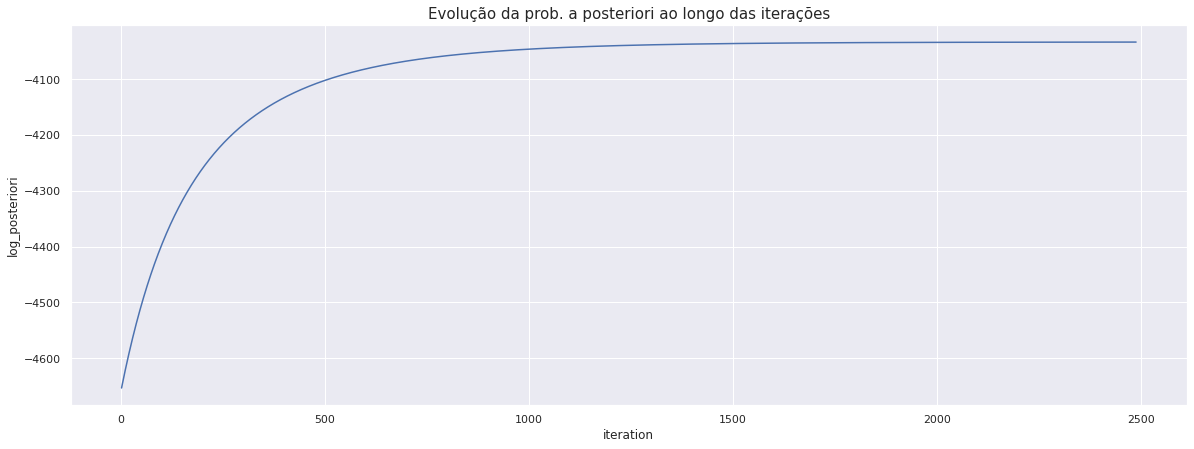

In [22]:
fig = plt.figure(figsize=(20,7))
sns.lineplot(
    data=logs,
    x='iteration',
    y='log_posteriori'
)
plt.title(
    'Evolução da prob. a posteriori ao longo das iterações',
    fontsize=15
)

Text(0.5, 1.0, 'Evolução do determinante de B ao longo das iterações')

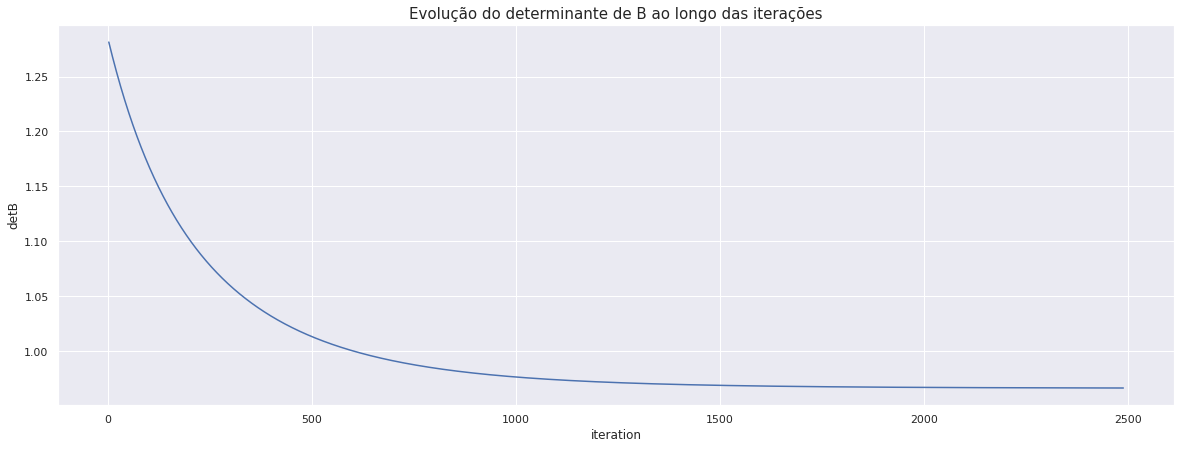

In [23]:
fig = plt.figure(figsize=(20,7))
sns.lineplot(
    data=logs,
    x='iteration',
    y='detB'
)
plt.title(
    'Evolução do determinante de B ao longo das iterações',
    fontsize=15
)

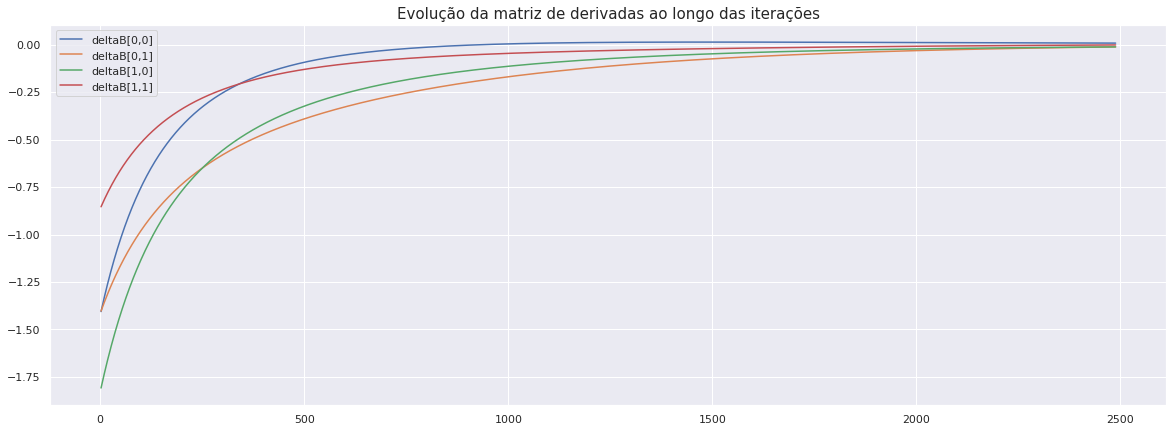

In [24]:
fig = plt.figure(figsize=(20,7))
for i, j in np.ndindex(B.shape):
    plt.plot(
        logs.iteration.values,
        [row['gradient'][i,j] for n, row in logs.iterrows()],
        label='deltaB[{},{}]'.format(i,j)
    )

plt.title(
    'Evolução da matriz de derivadas ao longo das iterações',
    fontsize=15
)
plt.legend()

In [25]:
B

array([[ 0.46613334, -1.06441064],
       [ 0.52092558,  0.88386054]])

In [26]:
np.linalg.inv(A)

array([[ 0.5, -1. ],
       [ 0.5,  1. ]])

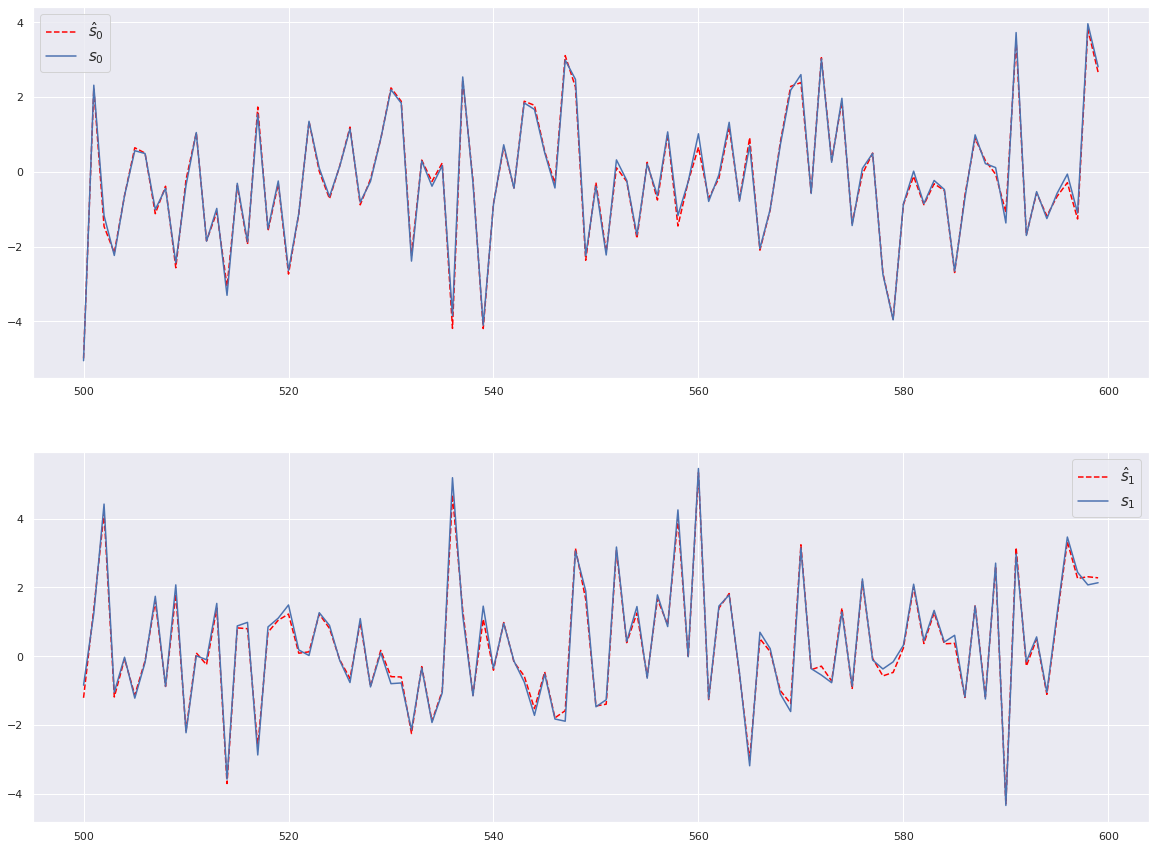

In [27]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(20,15)
)

NPOINTS=100
PLOT_START=NOBS//2
PLOT_END=PLOT_START+NPOINTS

t=range(NOBS)
s_est = B@x

#Ax1
ax1.plot(
    t[PLOT_START:PLOT_END],
    s_est[0,PLOT_START:PLOT_END],
    label='$\hat{s}_{0}$',
    color='red',
    linestyle='--'
)
ax1.plot(
    t[PLOT_START:PLOT_END],
    s[0,PLOT_START:PLOT_END],
    label='$s_{0}$'
)
ax1.legend(fontsize=15)

#Ax2
ax2.plot(
    t[PLOT_START:PLOT_END],
    s_est[1,PLOT_START:PLOT_END],
    label='$\hat{s}_{1}$',
    color='red',
    linestyle='--'
)
ax2.plot(
    t[PLOT_START:PLOT_END],
    s[1,PLOT_START:PLOT_END],
    label='$s_{1}$'
)
ax2.legend(fontsize=15)



In [28]:
# Error norm
print('Norma do erro de estimação: {}'.format(
np.linalg.norm(
    np.subtract(s,s_est)
)/np.size(s)))

Norma do erro de estimação: 0.0031809053753625908


# 5. Execute MAP optimization - standard gradient

In [29]:
def prior_pdf(B):
    sig=0.1
    desired_det=1
    return (1/np.sqrt(2*np.pi*np.square(sig)))*np.exp(-np.square(np.linalg.det(B)-desired_det)/(2*np.square(sig)))

def prior_pdf_derivative(B):
    sig=0.1
    return -1*prior_pdf(B=B)*(np.linalg.det(B)-1)/np.square(sig)

In [30]:
%%time

# Inicialização aleatória de B
B = initial_B
logs = pd.DataFrame()


continue_opt=True
n=1
last_posteriori = -np.inf
print('-'*100)
while continue_opt:
    # Determinação de gradiente
    deltaB = np.transpose(np.linalg.inv(B))
    deltaB = deltaB + (1/NOBS)*(prior_pdf_derivative(B)/prior_pdf(B))
    for t in range(NOBS):
        x_t = x[:,t]
        y_t = B@x_t
        g_y = np.array([
            source_pdf_derivative(y_t_i)/source_pdf(y_t_i) for y_t_i in y_t
        ]).reshape((NSOURCES,1))
        deltaB = deltaB + (1/NOBS)*(g_y@x_t.reshape((1,NSOURCES)))
    
    # Atualização de matriz de separação B
    B = B + learning_rate*deltaB
    
    # Cálculo de posteriori para registros
    posteriori = NOBS*np.log(np.abs(np.linalg.det(B)))
    y=B@x
    for i, j in np.ndindex(x.shape):
        posteriori += np.log(source_pdf(y[i,j]))
    
    logs = pd.concat(
        [
            logs,
            pd.DataFrame(
                index=[n],
                data={
                    'iteration': [n+1],
                    'detB': [np.linalg.det(B)],
                    'log_posteriori': [posteriori],
                    'gradient': [deltaB]
                }
            )
        ]
    )
    
    
    if n==1:
        n+=1
        continue_opt=True
        last_posteriori=posteriori
    else:
        n+=1
        # pdb.set_trace()
        continue_opt = (n<max_it) and (np.abs(posteriori-last_posteriori) > thresh)
        last_posteriori=posteriori
    
    if n%100==0:
        print('Iteração: {}'.format(n))
        print('Log-Posteriori: {}'.format(posteriori))
        print('-'*100)    
    
    

----------------------------------------------------------------------------------------------------


LinAlgError: Last 2 dimensions of the array must be square

In [31]:
fig = plt.figure(figsize=(20,7))
sns.lineplot(
    data=logs,
    x='iteration',
    y='log_posteriori'
)
plt.title(
    'Evolução da prob. a posteriori ao longo das iterações',
    fontsize=15
)

ValueError: Could not interpret value `iteration` for parameter `x`

<Figure size 1440x504 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(20,7))
sns.lineplot(
    data=logs,
    x='iteration',
    y='detB'
)
plt.title(
    'Evolução do determinante de B ao longo das iterações',
    fontsize=15
)

In [ ]:
fig = plt.figure(figsize=(20,7))
for i, j in np.ndindex(B.shape):
    plt.plot(
        logs.iteration.values,
        [row['gradient'][i,j] for n, row in logs.iterrows()],
        label='deltaB[{},{}]'.format(i,j)
    )

plt.title(
    'Evolução da matriz de derivadas ao longo das iterações',
    fontsize=15
)
plt.legend()

In [ ]:
B

In [ ]:
np.linalg.inv(A)

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(20,15)
)

NPOINTS=100
PLOT_START=NOBS//2
PLOT_END=PLOT_START+NPOINTS

t=range(NOBS)
s_est = B@x

#Ax1
ax1.plot(
    t[PLOT_START:PLOT_END],
    s_est[0,PLOT_START:PLOT_END],
    label='$\hat{s}_{0}$',
    color='red',
    linestyle='--'
)
ax1.plot(
    t[PLOT_START:PLOT_END],
    s[0,PLOT_START:PLOT_END],
    label='$s_{0}$'
)
ax1.legend(fontsize=15)

#Ax2
ax2.plot(
    t[PLOT_START:PLOT_END],
    s_est[1,PLOT_START:PLOT_END],
    label='$\hat{s}_{1}$',
    color='red',
    linestyle='--'
)
ax2.plot(
    t[PLOT_START:PLOT_END],
    s[1,PLOT_START:PLOT_END],
    label='$s_{1}$'
)
ax2.legend(fontsize=15)



In [ ]:
# Error norm
print('Norma do erro de estimação: {}'.format(
np.linalg.norm(
    np.subtract(s,s_est)
)/np.size(s)))

# 6. Execute MAP optimization - natural gradient

In [ ]:
%%time

# Inicialização aleatória de B
B = initial_B
logs = pd.DataFrame()


continue_opt=True
n=1
last_posteriori = -np.inf
print('-'*100)
while continue_opt:
    # Determinação de gradiente
    deltaB = np.transpose(np.linalg.inv(B))
    deltaB = deltaB + (1/NOBS)*(prior_pdf_derivative(B)/prior_pdf(B))
    for t in range(NOBS):
        x_t = x[:,t]
        y_t = B@x_t
        g_y = np.array([
            source_pdf_derivative(y_t_i)/source_pdf(y_t_i) for y_t_i in y_t
        ]).reshape((NSOURCES,1))
        deltaB = deltaB + (1/NOBS)*(g_y@x_t.reshape((1,NSOURCES)))
        
    deltaB = deltaB@np.transpose(B)@B

    
    deltaB = deltaB@B
    
    # Atualização de matriz de separação B
    B = B + learning_rate*deltaB
    
    # Cálculo de posteriori para registros
    posteriori = NOBS*np.log(np.abs(np.linalg.det(B)))
    y=B@x
    for i, j in np.ndindex(x.shape):
        posteriori += np.log(source_pdf(y[i,j]))
    
    logs = pd.concat(
        [
            logs,
            pd.DataFrame(
                index=[n],
                data={
                    'iteration': [n+1],
                    'detB': [np.linalg.det(B)],
                    'log_posteriori': [posteriori],
                    'gradient': [deltaB]
                }
            )
        ]
    )
    
    
    if n==1:
        n+=1
        continue_opt=True
        last_posteriori=posteriori
    else:
        n+=1
        # pdb.set_trace()
        continue_opt = (n<max_it) and (np.abs(posteriori-last_posteriori) > thresh)
        last_posteriori=posteriori
    
    if n%100==0:
        print('Iteração: {}'.format(n))
        print('Log-Posteriori: {}'.format(posteriori))
        print('-'*100)    
    
    

In [ ]:
fig = plt.figure(figsize=(20,7))
sns.lineplot(
    data=logs,
    x='iteration',
    y='log_posteriori'
)
plt.title(
    'Evolução da prob. a posteriori ao longo das iterações',
    fontsize=15
)

In [ ]:
fig = plt.figure(figsize=(20,7))
sns.lineplot(
    data=logs,
    x='iteration',
    y='detB'
)
plt.title(
    'Evolução do determinante de B ao longo das iterações',
    fontsize=15
)

In [ ]:
fig = plt.figure(figsize=(20,7))
for i, j in np.ndindex(B.shape):
    plt.plot(
        logs.iteration.values,
        [row['gradient'][i,j] for n, row in logs.iterrows()],
        label='deltaB[{},{}]'.format(i,j)
    )

plt.title(
    'Evolução da matriz de derivadas ao longo das iterações',
    fontsize=15
)
plt.legend()

In [ ]:
B

In [ ]:
np.linalg.inv(A)

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(20,15)
)

NPOINTS=100
PLOT_START=NOBS//2
PLOT_END=PLOT_START+NPOINTS

t=range(NOBS)
s_est = B@x

#Ax1
ax1.plot(
    t[PLOT_START:PLOT_END],
    s_est[0,PLOT_START:PLOT_END],
    label='$\hat{s}_{0}$',
    color='red',
    linestyle='--'
)
ax1.plot(
    t[PLOT_START:PLOT_END],
    s[0,PLOT_START:PLOT_END],
    label='$s_{0}$'
)
ax1.legend(fontsize=15)

#Ax2
ax2.plot(
    t[PLOT_START:PLOT_END],
    s_est[1,PLOT_START:PLOT_END],
    label='$\hat{s}_{1}$',
    color='red',
    linestyle='--'
)
ax2.plot(
    t[PLOT_START:PLOT_END],
    s[1,PLOT_START:PLOT_END],
    label='$s_{1}$'
)
ax2.legend(fontsize=15)



In [ ]:
# Error norm
print('Norma do erro de estimação: {}'.format(
np.linalg.norm(
    np.subtract(s,s_est)
)/np.size(s)))